In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import unicodedata
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [30]:
ufc = pd.read_csv('data.csv')
odds = pd.read_csv('UFC_betting_odds.csv')

/tmp/ipykernel_462033/1852894375.py:2: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  odds = pd.read_csv('UFC_betting_odds.csv')


In [33]:
def clean_name(x):
    if pd.isna(x):
        return None
        
    x = x.lower().strip()
    x = ''.join(
        c for c in unicodedata.normalize('NFKD', x)
        if not unicodedata.combining(c)
    )
    x = x.replace('-', ' ')
    x = re.sub(r'\s+', ' ', x)
    return x

In [34]:
odds["fighter_1"] = odds["fighter_1"].str.lower().str.strip()
odds["fighter_2"] = odds["fighter_2"].str.lower().str.strip()

In [35]:
def american_to_prob(x):
    if pd.isna(x):
        return np.nan
    if x > 0:
        return 100 / (x + 100)
    else:
        return -x / (-x + 100)

odds["prob1"] = odds["odds_1"].apply(american_to_prob)
odds["prob2"] = odds["odds_2"].apply(american_to_prob)

In [36]:
df = ufc.merge(
    odds,
    left_on=["R_fighter", "B_fighter"],
    right_on=["fighter_1", "fighter_2"],
    how="inner"
)

In [37]:
df["favorite_prob"] = df[["prob1", "prob2"]].max(axis=1)

df["favorite_name"] = np.where(
    df["prob1"] >= df["prob2"],
    df["R_fighter"],
    df["B_fighter"]
)
df["favorite_won"] = (df["Winner"] == df["favorite_name"])

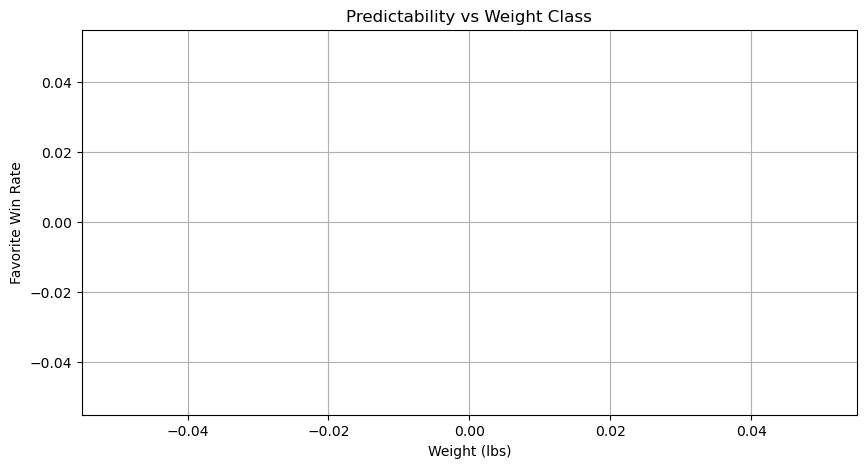

In [38]:
weight_map = {
    "Flyweight": 125,
    "Bantamweight": 135,
    "Featherweight": 145,
    "Lightweight": 155,
    "Welterweight": 170,
    "Middleweight": 185,
    "LightHeavyweight": 205,
    "Heavyweight": 265,
    "WomenStrawweight": 115,
    "WomenFlyweight": 125,
    "WomenBantamweight": 135,
    "WomenFeatherweight": 145
}

df["weight_num"] = df["weight_class"].map(weight_map)
df_clean = df.dropna(subset=["weight_num", "favorite_won"])

predict = df_clean.groupby("weight_num")["favorite_won"].mean()

plt.figure(figsize=(10,5))
plt.plot(predict.index, predict.values, marker='o')
plt.title("Predictability vs Weight Class")
plt.xlabel("Weight (lbs)")
plt.ylabel("Favorite Win Rate")
plt.grid(True)
plt.show()

In [26]:
print(df_clean["favorite_won"].value_counts())
print(df_clean.groupby("weight_num")["favorite_won"].mean())

favorite_won
False    5059
Name: count, dtype: int64
weight_num
115.0    0.0
125.0    0.0
135.0    0.0
145.0    0.0
155.0    0.0
170.0    0.0
185.0    0.0
205.0    0.0
265.0    0.0
Name: favorite_won, dtype: float64


/tmp/ipykernel_462033/352994993.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gap=df.groupby('weight_class').apply(lambda x: x['fav_implied'].mean()-x['favorite_won'].mean())


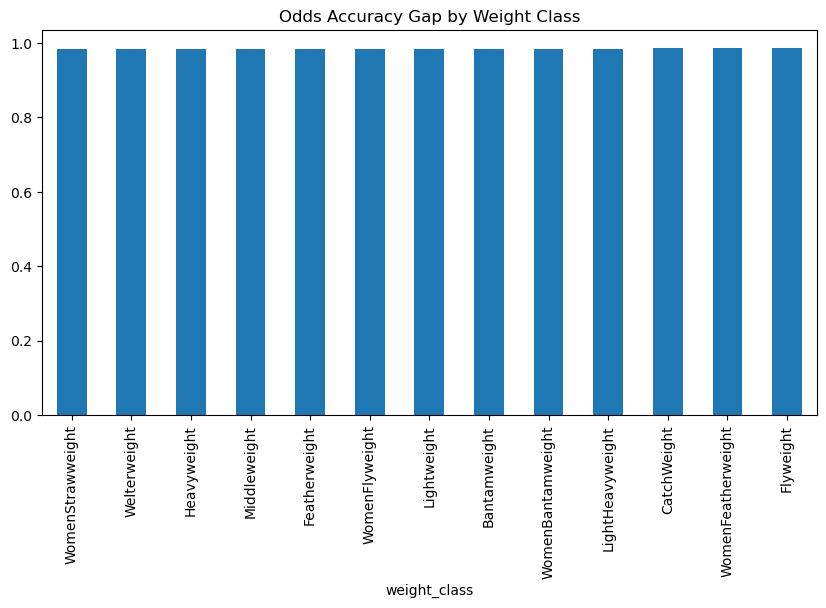

In [21]:
df['fav_implied']=df['favorite_prob']
gap=df.groupby('weight_class').apply(lambda x: x['fav_implied'].mean()-x['favorite_won'].mean())
plt.figure(figsize=(10,5))
gap.sort_values().plot(kind='bar')
plt.title('Odds Accuracy Gap by Weight Class')
plt.show()